<a href="https://colab.research.google.com/github/T0gan/KTHack2020-Neural-Qubits/blob/main/QCNN_model_2_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Tensorflow'u ve kuantum kütüphanesi indirmemiz gerekiyor.
# (colab içindir, bilgisayarınızda kuruluysa bu kısmı silin)
!pip install tensorflow-quantum
!pip install cirq

# 1) Kütüphanelerin Eklenmesi

In [2]:
# Kullanılacak kütüphaneleri import edelim.
import tensorflow as tf 
import tensorflow_quantum as tfq 
import cirq 
import sympy 
import numpy as np 
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


# 2) Verisetinin Hazırlanması

In [3]:
# Notebook'ta keras içindeki hazır verisetlerinden olan MNIST veriseti kullanılacak.
# Önce verileri eğitim ve test olmak üzere ayıralım.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Verilerimizin olduğu listeye ekstra bir dimension ekledik.
# (ilgili link: https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it)
# Ve tüm pikselleri [0, 255] aralığından [0.0, 1.0] aralığına dönüştürülerek normalize ettik.
# (resmimiz gri skalada olduğu için piksel değerleri [0, 255] aralığındadır)
x_train = x_train[..., np.newaxis]/255.0
x_test = x_test[..., np.newaxis]/255.0

print("Verisetindeki eğitim resmi sayısı:", len(x_train))
print("Verisetindeki test resmi sayısı  :", len(x_test))

Verisetindeki eğitim resmi sayısı: 60000
Verisetindeki test resmi sayısı  : 10000


In [4]:
# Bu fonksiyon verisetindeki 10 sınıfı (0-9), sadece 0 ve 1 rakamı olacak şekilde 2 sınıfa indirger
def filter_01(x, y):
    # Eğitim ve test verisetinin etiketleri için filtre uyguladık
    # `np.where` 0 ve 1 etiketlerinin bulunduğu indekslerin listesini döndürür.
    # Bu listeyi x ve y listelerine verdiğimizde 0 ve 1 etiketine sahip verileri elde ederiz.
    x = x[np.where((y == 1) | (y == 0))]
    y = y[np.where((y == 1) | (y == 0))]

    # Etiket listesine son bir işlem uygulayıp 1 olan değerleri True, 0 olanları False yaparız.
    # Yani sınıflandırma sonucunda True çıkarsa o resmin 1 olarak tahmin edildiği anlamına gelir.
    y = y == 1

    return x,y

In [5]:
# Sadece 3 ve 6 sınıfının bulunduğu yeni listemizi elde ederiz.
x_train, y_train = filter_01(x_train, y_train)
x_test, y_test = filter_01(x_test, y_test)

print("Filtrelenmiş eğitim resmi sayısı:", len(x_train))
print("Filtrelenmiş test resmi sayısı:", len(x_test))

Filtrelenmiş eğitim resmi sayısı: 12665
Filtrelenmiş test resmi sayısı: 2115


In [6]:
# MNIST verisetindeki resimler 28x28 pikseldir.
# Kuantum programlamada kullanılacak kübit sayısındaki bazı sınırlardan dolayı,
# resimlerimizin boyutunu 6x6 piksele düşüreceğiz.
x_train_small = tf.image.resize(x_train, (6, 6)).numpy()
x_test_small = tf.image.resize(x_test, (6, 6)).numpy()

In [7]:
# Bu fonksiyon etiketlerimizi PQC katmanında kullanılmak üzere -1 ve 1 değerlerine dönüştürür.
def convert_label(y):
  if y == True:
    return 1.0
  else: 
    return -1.0

In [8]:
y_train_converted = [convert_label(y) for y in y_train]
y_test_converted = [convert_label(y) for y in y_test]

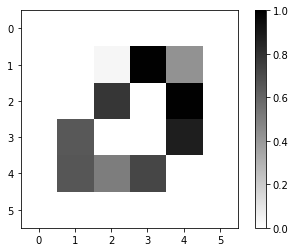

In [9]:
# 6x6 piksele düşürülen bir resim şu şekilde gözükecektir:
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1, cmap=plt.get_cmap("binary"))
plt.colorbar()

In [10]:
x_train_small_sub = x_train_small[:300]
x_test_small_sub = x_test_small[:100]

y_train_sub = y_train_converted[:300]
y_test_sub = y_test_converted[:100]

# 3) Kuantum Modelinin İnşa Edilmesi

In [11]:
#Try 4 qubit gates -- to be improved later

from sympy.physics.quantum import TensorProduct
class ZZZZ(cirq.Gate):
  def __init__(self, symbols):
    self.symbols=symbols
  def _num_qubits_(self) -> int:
    return 4
  def _unitary_(self):
    return TensorProduct(cirq.unitary(cirq.ZZ),cirq.unitary(cirq.ZZ))**self.symbols
  def __str__(self):
    return 'ZZZZ'


class XXXX(cirq.Gate):
  def __init__(self, symbols):
    self.symbols=symbols
  def _num_qubits_(self) -> int:
    return 4
  def _unitary_(self):
    return TensorProduct(cirq.unitary(cirq.XX),cirq.unitary(cirq.XX))**self.symbols
  def __str__(self):
    return 'XXXX'

class YYYY(cirq.Gate):
  def __init__(self, symbols):
    self.symbols=symbols
  def _num_qubits_(self) -> int:
    return 4
  def _unitary_(self):
    return TensorProduct(cirq.unitary(cirq.YY),cirq.unitary(cirq.YY))**self.symbols
  def __str__(self):
    return 'YYYY'

In [12]:

# Convolutional katmanı
def one_qubit_unitary(bit, symbols):

    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])

def conv_filter_xyz(bits, symbols):
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += one_qubit_unitary(bits[2], symbols[6:9])
    circuit += one_qubit_unitary(bits[3], symbols[9:12])
    
    for first, second in zip(bits[0::2], bits[1::2]):
      circuit += [cirq.ZZ(first,second)**symbols[12]]
      circuit += [cirq.YY(first,second)**symbols[13]]
      circuit += [cirq.XX(first,second)**symbols[14]]

    circuit += one_qubit_unitary(bits[0], symbols[15:18])
    circuit += one_qubit_unitary(bits[1], symbols[18:21])
    circuit += one_qubit_unitary(bits[2], symbols[21:24])
    circuit += one_qubit_unitary(bits[3], symbols[24:])


    #pooling
    circuit+=cirq.CNOT(control=bits[0], target=bits[1])
    circuit+=cirq.CNOT(control=bits[2], target=bits[3])
    circuit+=cirq.CNOT(control=bits[1], target=bits[3])
    return circuit



In [13]:
import random

def conv_filter(qubits, symbols):
  circuit=cirq.Circuit()
  gate_set=[cirq.rx, cirq.ry, cirq.rz]

  for i,q in enumerate(qubits):
    chosen_gate=random.choice(gate_set)
    circuit+=chosen_gate(symbols[i])(q)
  
  for control, target in zip(qubits, qubits[1:]+[qubits[0]]):
    circuit+=cirq.CZ(control, target)
  circuit+=cirq.CNOT(control=qubits[0], target=qubits[1])
  circuit+=cirq.CNOT(control=qubits[2], target=qubits[3])
  circuit+=cirq.CNOT(control=qubits[1], target=qubits[3])
  return circuit




findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


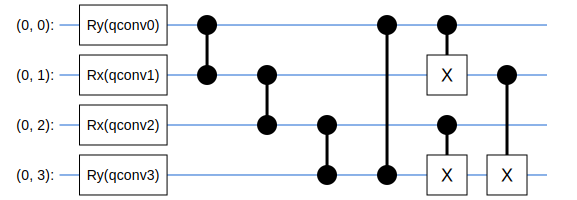

In [14]:
qubits=cirq.GridQubit.rect(1,4)
symbols=sympy.symbols('qconv0:100')
SVGCircuit(conv_filter(qubits, symbols))

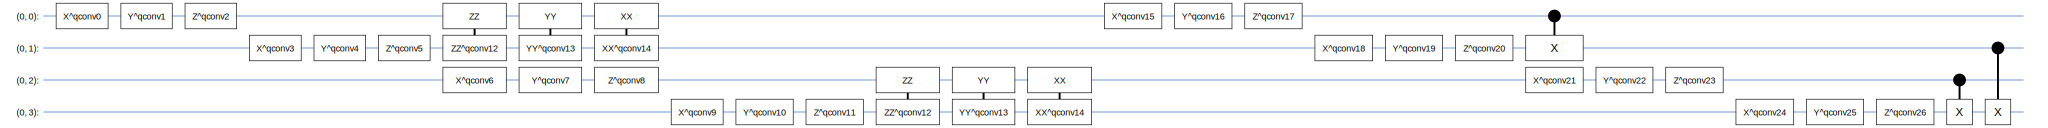

In [15]:
qubits=cirq.GridQubit.rect(1,4)
symbols=sympy.symbols('qconv0:100')
SVGCircuit(conv_filter_xyz(qubits, symbols))

In [16]:
def conv_circuit(bits, symbols): #bütün bitler -- sliding burada
  circuit=cirq.Circuit()
  n=int(np.sqrt(len(bits)))
  patch=np.array(bits).reshape((n,n))
  count=0
  for j in range(0,n,2):
    for k in range(0,n,2):
      
      circuit+= conv_filter_xyz([patch[j,k], patch[j,k+1], patch[j+1,k], patch[j+1,k+1]], symbols[count:count+27])
      count+=27
  return circuit
  


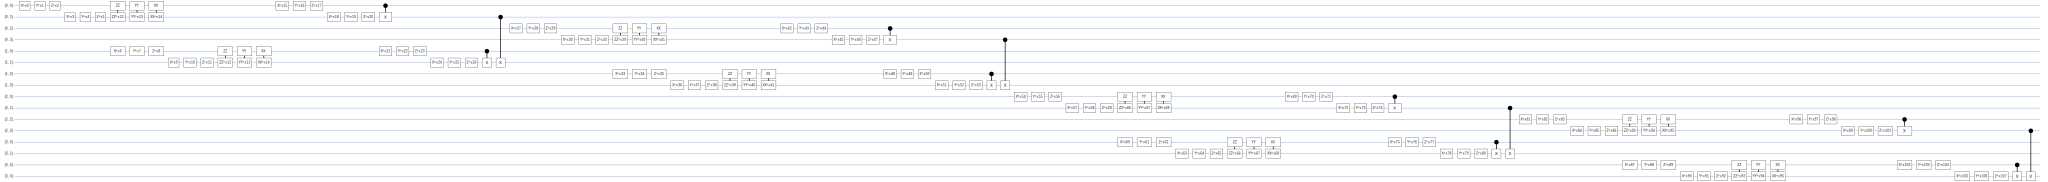

In [17]:
SVGCircuit(conv_circuit(cirq.GridQubit.rect(4,4), sympy.symbols('x0:200')))

In [18]:
index=[5,7,13,15]

In [19]:
def create_model(qubits):
  model_circuit=cirq.Circuit()
  symbols=sympy.symbols('qconv0:200')
  model_circuit+=conv_circuit(qubits, symbols[:108])
  index=[5,7,13,15]
  model_circuit+=conv_circuit([qubits[i] for i in index], symbols[108:])
  return model_circuit

qubits16=cirq.GridQubit.rect(4,4)
readout_operators=cirq.Z(qubits16[-1])

model=tf.keras.Sequential([tf.keras.layers.Input(shape=(), dtype=tf.string), 
                           tfq.layers.PQC(create_model(qubits16), readout_operators)])



# 4) Resimlerin Kuantum Devrelerine Kodlanması

In [20]:
# Bu fonksiyon, her bir resmimizi kübitlerde depolayabilmek için gerekli devreleri oluşturur.
def encode_circuit_16(values):
  im4=values[1:5,1:5]
  phi=np.ndarray.flatten(im4)
  encode_circuit=cirq.Circuit()
  qubits=cirq.GridQubit.rect(4,4)
  for i in range(16):
    encode_circuit.append(cirq.ry(np.pi*phi[i])(qubits[i]))
  return encode_circuit

In [21]:
x_train_16 = [encode_circuit_16(x) for x in x_train_small_sub]
x_test_16 = [encode_circuit_16(x) for x in x_test_small_sub]

In [22]:
# Verilerimizi gerekli işlemleri yapabilmek için tensörlere çevirelim.
x_train_tensor_16 = tfq.convert_to_tensor(x_train_16)
x_test_tensor_16 = tfq.convert_to_tensor(x_test_16)

In [23]:
@tf.function
def custom_accuracy(y_true, y_pred):
  y_true=tf.squeeze(y_true)
  y_pred=tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
  return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

In [24]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

# 5) Modelin Derlenmesi

In [25]:
# Modelimizi kayıp fonksiyonu olarak Hinge ve optimizer olarak Adam algortimasını seçerek derleyelim.
model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.losses.Hinge(),
                   metrics=[hinge_accuracy])

In [26]:
# Eğittimiz modelin özeti de şu şekildedir:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 135       
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________
None


# 6) Modelin Eğitilmesi

In [27]:
# Model eğitiminin ne kadar süreceğini ölçmek için eğitimden önce zamanı kaydedelim.
import time
start_time = time.time()

In [28]:
# Modelimizi eğitelim.
history = model.fit(x=x_train_tensor_16,
                         y=np.asarray(y_train_sub),
                         batch_size=16,
                         epochs=20,
                         verbose=1,
                         validation_data=(x_test_tensor_16, np.asarray(y_test_sub)))

Epoch 1/20
19/19 [==============================] - 21s 1s/step - loss: 1.0075 - hinge_accuracy: 0.4792 - val_loss: 0.9941 - val_hinge_accuracy: 0.5893
Epoch 2/20
19/19 [==============================] - 25s 1s/step - loss: 0.9935 - hinge_accuracy: 0.5395 - val_loss: 0.9858 - val_hinge_accuracy: 0.6607
Epoch 3/20
19/19 [==============================] - 21s 1s/step - loss: 0.9864 - hinge_accuracy: 0.5811 - val_loss: 0.9788 - val_hinge_accuracy: 0.6339
Epoch 4/20
19/19 [==============================] - 21s 1s/step - loss: 0.9787 - hinge_accuracy: 0.6140 - val_loss: 0.9641 - val_hinge_accuracy: 0.6875
Epoch 5/20
19/19 [==============================] - 21s 1s/step - loss: 0.9657 - hinge_accuracy: 0.6447 - val_loss: 0.9420 - val_hinge_accuracy: 0.7500
Epoch 6/20
19/19 [==============================] - 21s 1s/step - loss: 0.9422 - hinge_accuracy: 0.7489 - val_loss: 0.8868 - val_hinge_accuracy: 0.7768
Epoch 7/20
19/19 [==============================] - 21s 1s/step - loss: 0.8941 - hinge_a

In [29]:
# Başlangıçtaki zamana bakarak eğitimin kaç saniye sürdüğünü yazdıralım.
print(f"Model eğitimi {time.time() - start_time} saniye sürdü.")

Model eğitimi 452.013534784317 saniye sürdü.


In [30]:
# Modelimizin doğruluğuna baktığımızda 0.80 civarı olduğunu görebiliriz.
qcnn_results = model.evaluate(x_test_tensor_16, np.asarray(y_test_sub))

qcnn_accuracy = qcnn_results[1]
qcnn_accuracy

4/4 [==============================] - 0s 84ms/step - loss: 0.4368 - hinge_accuracy: 0.7422


0.7421875

# 7) Değerlendirme

In [31]:
preds = model.predict_classes(x_test_tensor_16)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


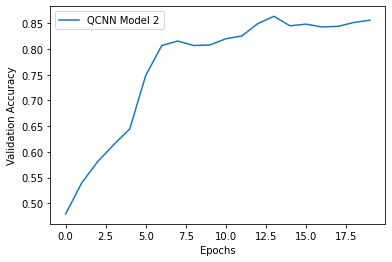

In [32]:


plt.plot(history.history['hinge_accuracy'], label='QCNN Model 2')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()

In [33]:
print(history.history['hinge_accuracy'])

[0.4791666865348816, 0.5394737124443054, 0.5811403393745422, 0.6140351295471191, 0.6447368264198303, 0.7489035129547119, 0.8070175051689148, 0.8157894611358643, 0.8070175051689148, 0.8081140518188477, 0.8201754093170166, 0.8256579041481018, 0.8497807383537292, 0.8640350699424744, 0.8453947305679321, 0.8486841917037964, 0.8432018160820007, 0.8442981839179993, 0.8519737124443054, 0.8563596606254578]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


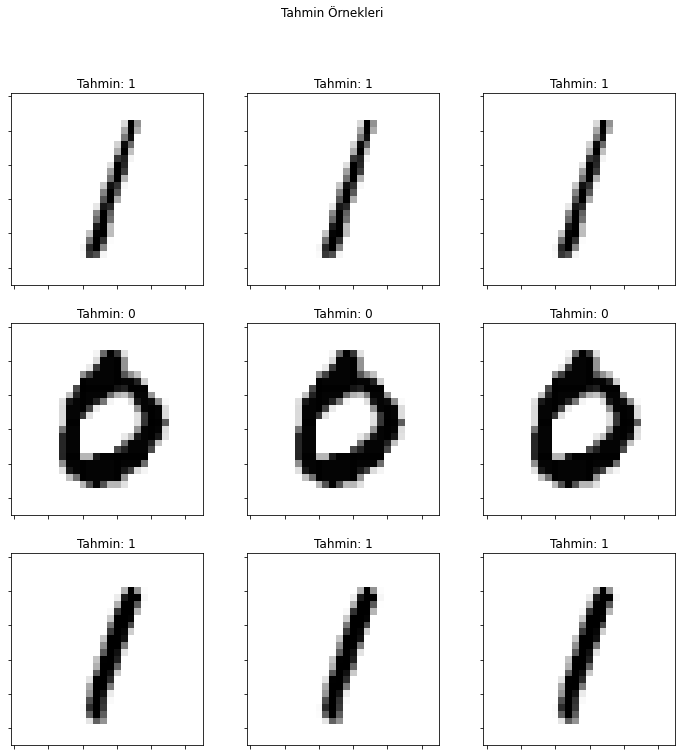

In [34]:
# Tahmin ettiğimiz bazı verilerden birkaçını ve tahminlerimizi gösterelim.
import random
from matplotlib.gridspec import GridSpec

ilk_indeks = random.randint(0, len(x_test)-10)

fig = plt.figure(figsize=(12, 12))

gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

for i in range(3):
  for j in range(3):
    ax = fig.add_subplot(gs[i, j])
    ax.title.set_text("Tahmin: " +  str(preds[i][0]))
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.imshow(x_test[i,:,:,0], cmap=plt.get_cmap("binary"))

fig.suptitle("Tahmin Örnekleri")

plt.show()